# Independent Components Analysis Implemetation

In [17]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

We define g and g’ which we’ll use to determine the new value for w

In [2]:
def g(x):
    return np.tanh(x)
def g_der(x):
    return 1 - g(x) * g(x)

We create a function to center the signal by subtracting the mean

In [3]:
def center(X):
    X = np.array(X)
    
    mean = X.mean(axis=1, keepdims=True)
    
    return X-mean

We define a function to whiten the signal using the method described above

In [4]:
def whitening(X):
    cov = np.cov(X)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
    return X_whiten

We define a function to update the de-mixing matrix w

In [5]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

Finally, we define the main method which calls the preprocessing functions, initializes w to some random set of values and iteratively updates w. Again, convergence can be judged by the fact that an ideal w would be orthogonal, and hence w multiplied by its transpose would be approximately equal to 1. After computing the optimal value of w for each component, we take the dot product of the resulting matrix and the signal x to get the sources.

In [11]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    
    X = whitening(X)
        
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    for i in range(components_nr):
        
        w = np.random.rand(components_nr)
        
        for j in range(iterations):
            
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                break
                
        W[i, :] = w
        
    S = np.dot(W, X)
    
    return S

We define a function to plot and compare the original, mixed and predicted signals.

In [12]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()
    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")
    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")
    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

For the sake of the proceeding example, we create a method to artificially mix different source signals.

In [13]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

Then, we create 3 signals, each with its own distinct pattern.

In [14]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)  # sinusoidal
s2 = np.sign(np.sin(3 * time))  # square signal
s3 = signal.sawtooth(2 * np.pi * time)  # saw tooth signal

In the proceeding example, we compute the dot product of the matrix A and the signals to obtain a combination of all three. We then use Independent Component Analysis to separate the mixed signal into the original source signals.

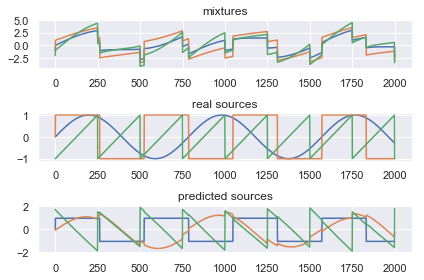

In [15]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=1000)
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

Usage of FastICA Algorithm

In [7]:
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

np.random.seed(0)  # set seed for reproducible results
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: sawtooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

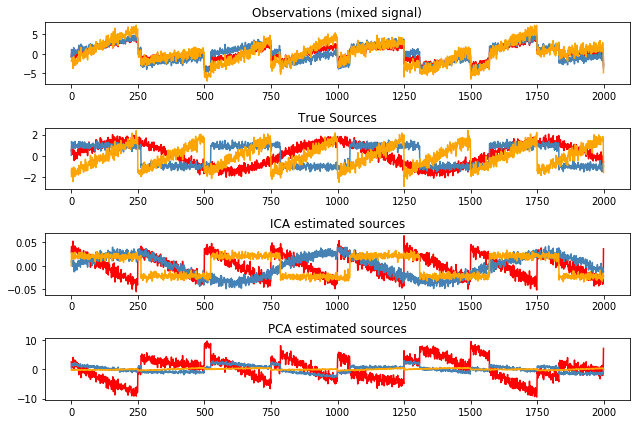

In [8]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Get the estimated sources
A_ = ica.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA estimated sources',
         'PCA estimated sources']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()

Another Example

Like other dimensionality reduction methods, ICA seeks to reduce the number of variables in a set of data, while retaining key information. In the example we lay out in this post, the variables represent pixels in an image. One of the motivations behind using ICA on images is to perform image compression i.e. rather than storing thousands or even millions of pixels in a image, the storage of the independent components takes up much less memory. Also, by its nature, ICA extracts the independent components of images — which means that it will find the curves and edges within an image. For example, in facial recognition, ICA will identify the eyes, the nose, the mouth etc. as independent components.

In [22]:
from sklearn.decomposition import FastICA
from pylab import *
from skimage import data, io, color

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [23]:
emc2_image = io.imread("emc2_original.png", as_grey = True)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


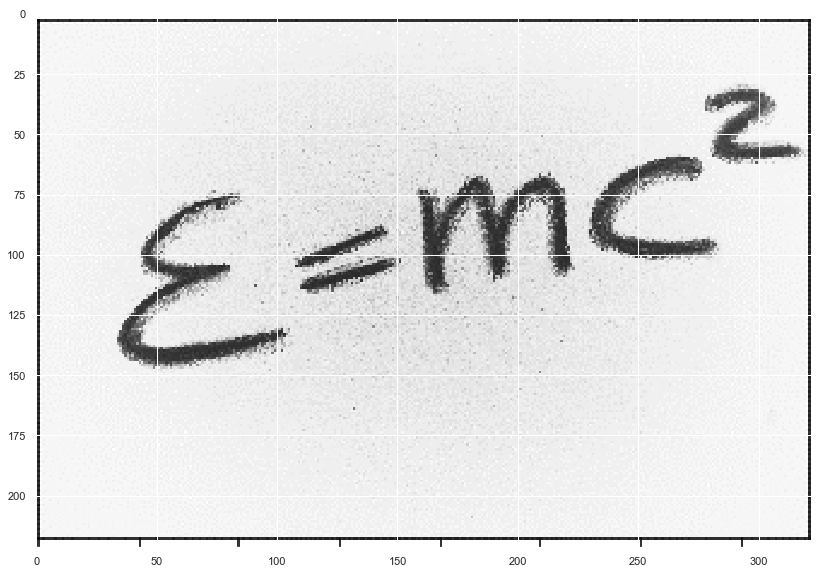

In [24]:
io.imshow(emc2_image)
show()

In [12]:
ica = FastICA(n_components = 10)
ica.fit(emc2_image)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=10, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

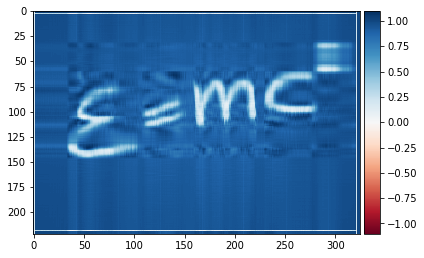

In [13]:
# reconstruct image with independent components
emc2_image_ica = ica.fit_transform(emc2_image)
emc2_restored = ica.inverse_transform(emc2_image_ica)
 
# show image to screen
io.imshow(emc2_restored)
show()

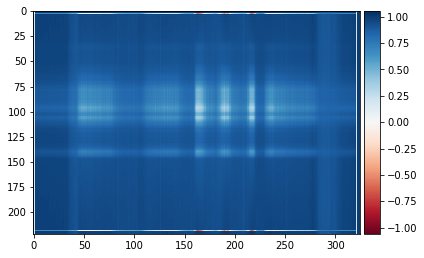

In [14]:
ica = FastICA(n_components = 1)
ica.fit(emc2_image)
emc2_image_ica = ica.fit_transform(emc2_image)
emc2_restored = ica.inverse_transform(emc2_image_ica)
 
# show image to screen
io.imshow(emc2_restored)
show()

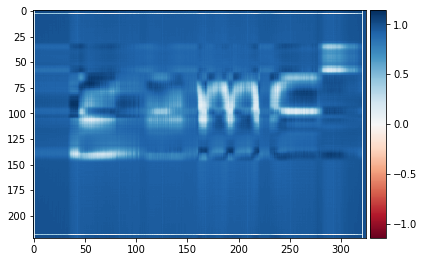

In [15]:
ica = FastICA(n_components = 5)
ica.fit(emc2_image)
emc2_image_ica = ica.fit_transform(emc2_image)
emc2_restored = ica.inverse_transform(emc2_image_ica)
 
# show image to screen
io.imshow(emc2_restored)
show()

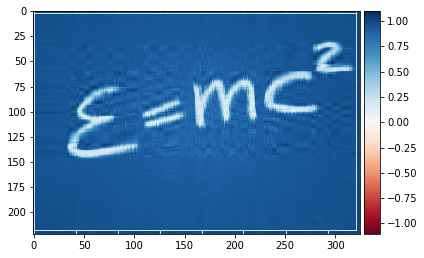

In [16]:
ica = FastICA(n_components = 20)
ica.fit(emc2_image)
emc2_image_ica = ica.fit_transform(emc2_image)
emc2_restored = ica.inverse_transform(emc2_image_ica)
 
# show image to screen
io.imshow(emc2_restored)
show()